In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import numpy as np
from theano import theano, tensor as tt
pm.set_tt_rng(44)
np.random.seed(44)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Jonathan\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Jonathan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._c

In [2]:
#https://ferrine.github.io/blog/2017/07/11/normalizing-flows-overview/
#Try applying IAF and HF to these posteriors to compare
pm.NormalizingFlow 
pm.NFVI

pymc3.variational.inference.NFVI

In [3]:
def w1(z):
    return tt.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tt.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tt.exp(-(z[0]-1.)/.3))**-1
def pot1(z):
    z = z.T
    return .5*((z.norm(2, axis=0)-2.)/.4)**2 - tt.log(tt.exp(-.5*((z[0]-2.)/.6)**2) + tt.exp(-.5*((z[0]+2.)/.6)**2))
def pot2(z):
    z = z.T
    return .5*((z[1]-w1(z))/.4)**2
def pot3(z):
    z = z.T
    return -tt.log(tt.exp(-.5*((z[1]-w1(z))/.35)**2) + tt.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2))
def pot4(z):
    z = z.T
    return -tt.log(tt.exp(-.5*((z[1]-w1(z))/.4)**2) + tt.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2))

z = tt.matrix('z')
z.tag.test_value = pm.floatX([[0., 0.]])
pot1f = theano.function([z], pot1(z))
pot2f = theano.function([z], pot2(z))
pot3f = theano.function([z], pot3(z))
pot4f = theano.function([z], pot4(z))

In [4]:
def contour_pot(potf, ax=None, title=None, xlim=5, ylim=5):
    grid = pm.floatX(np.mgrid[-xlim:xlim:100j,-ylim:ylim:100j])
    grid_2d = grid.reshape(2, -1).T
    cmap = plt.get_cmap('inferno')
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    pdf1e = np.exp(-potf(grid_2d))
    contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap)
    if title is not None:
        ax.set_title(title, fontsize=16)
    return ax

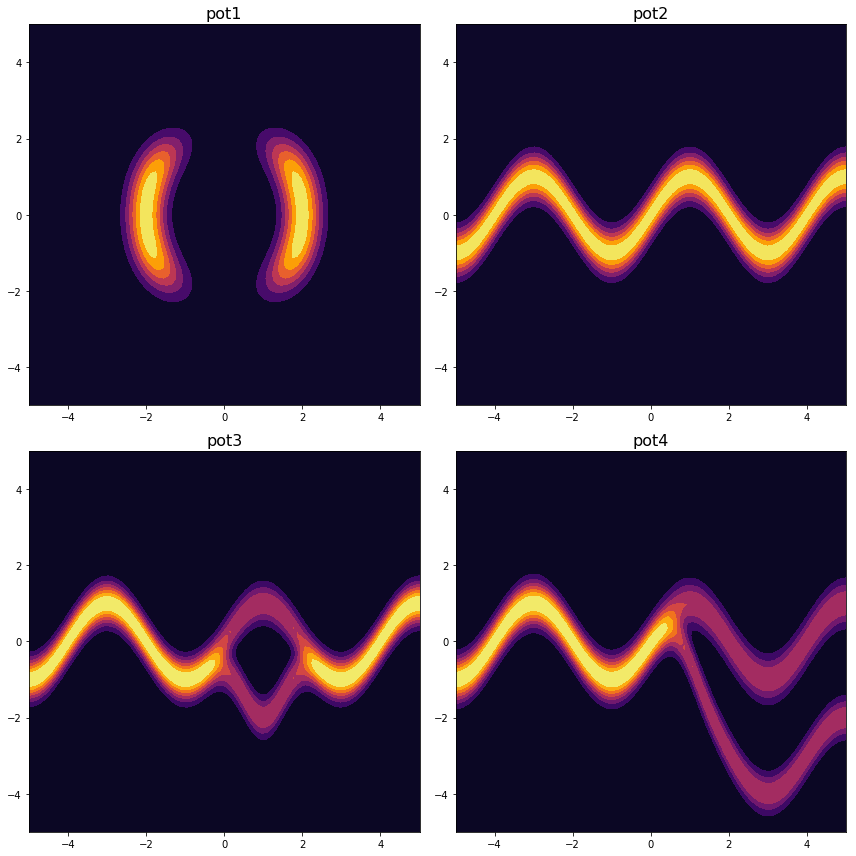

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
contour_pot(pot1f, ax[0], 'pot1', );
contour_pot(pot2f, ax[1], 'pot2');
contour_pot(pot3f, ax[2], 'pot3');
contour_pot(pot4f, ax[3], 'pot4');
fig.tight_layout()
plt.savefig('NF_posteriors.png')

In [7]:
with pm.Model() as pot1m:
    pm.DensityDist('pot1', lambda x: -pot1(x), shape=(2,))

In [8]:
with pot1m:
    trace = pm.sample(10000, init=None, start=dict(pot1=np.array([2, 0])))

C:\Users\Jonathan\Anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pot1]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
NUTS: [pot1]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:48<00:00, 215.53it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


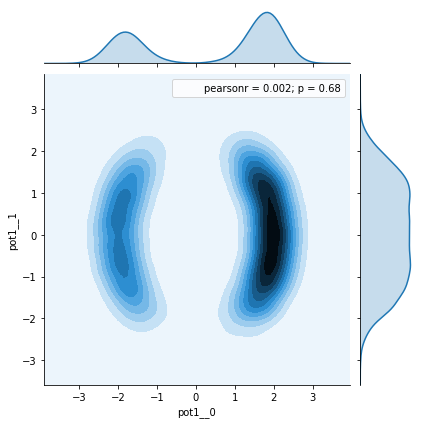

In [9]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

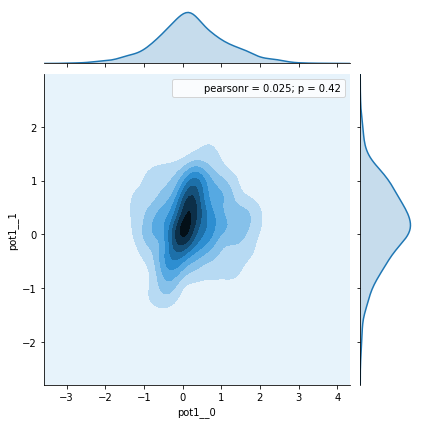

In [10]:
pm.set_tt_rng(2018)
np.random.seed(2018)
with pot1m:
    inference = pm.NFVI('planar*2', jitter=1)
## Plotting starting distribution
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde');

In [11]:
inference.approx.params

[b, u, w, b, u, w]

In [12]:
inference.objective(nmc=None)

Elemwise{mul,no_inplace}.0

In [13]:
from collections import defaultdict
from itertools import count

@theano.configparser.change_flags(compute_test_value='off')
def get_tracker(inference):
    numbers = defaultdict(count)
    params = inference.approx.params
    grads = tt.grad(inference.objective(None), params)
    names = ['%s_%d' % (v.name, next(numbers[v.name])) for v in inference.approx.params]
    return pm.callbacks.Tracker(**dict(
      [(name, v.eval) for name, v in zip(names, params)] + [('grad_' + name, v.eval) for name, v in zip(names, grads)]
    ))
tracker = get_tracker(inference)

In [14]:
inference.fit(60000, obj_optimizer=pm.adam(learning_rate=0.01), callbacks=[tracker])

Average Loss = -1.136: 100%|█████████████████████████████████████████████████████| 60000/60000 [22:35<00:00, 44.28it/s]
Finished [100%]: Average Loss = -1.1383


In [17]:
from collections import Counter
def plot_tracker_results(tracker, savefig):
    fig, ax = plt.subplots(len(tracker.hist)//2, 2, figsize=(16, len(tracker.hist)//2*2.3))
    ax = ax.flatten()
    names = list(tracker.hist.keys())
    gnames = names[len(names)//2:]
    names = names[:len(names)//2]
    pairnames = zip(names, gnames)
    def plot_params_and_grads(name, gname):
        i = names.index(name)
        left = ax[i*2]
        right = ax[i*2+1]
        grads = np.asarray(tracker[gname])
        if grads.ndim == 1:
            grads = grads[:, None]
        grads = grads.T
        params = np.asarray(tracker[name])
        if params.ndim == 1:
            params = params[:, None]
        params = params.T
        right.set_title('Gradient of %s' % name)
        left.set_title('Param trace of %s' % name)
        s = params.shape[0]
        for j, (v, g) in enumerate(zip(params, grads)):
            left.plot(v, '-')
            right.plot(g, 'o', alpha=1/s/10)
        left.legend([name + '_%d' % j for j in range(len(names))])
        right.legend([gname + '_%d' % j for j in range(len(names))])

    for vn, gn in pairnames:
        plot_params_and_grads(vn, gn)
    fig.tight_layout()
    plt.savefig(savefig)

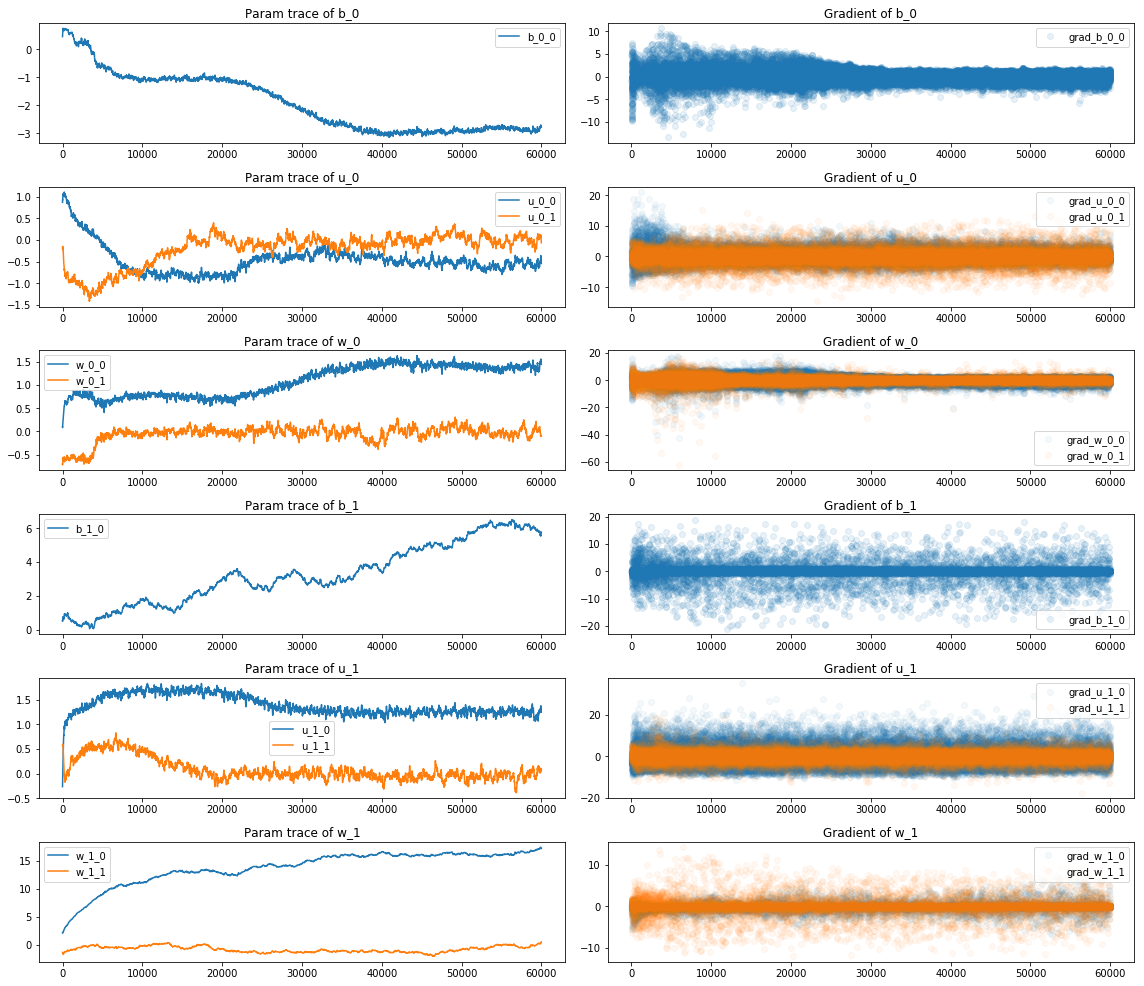

In [18]:
plot_tracker_results(tracker, "NF_flows_2_pot1.png")

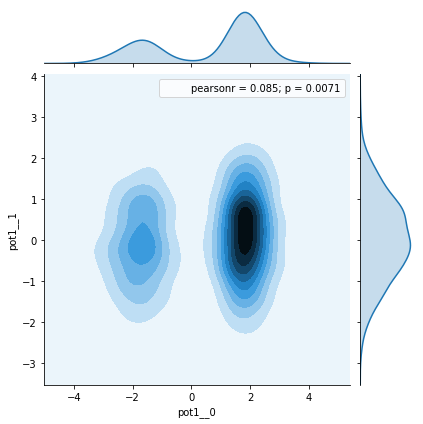

In [20]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')
plt.savefig("NF_flows_2_pot1_kde.png")

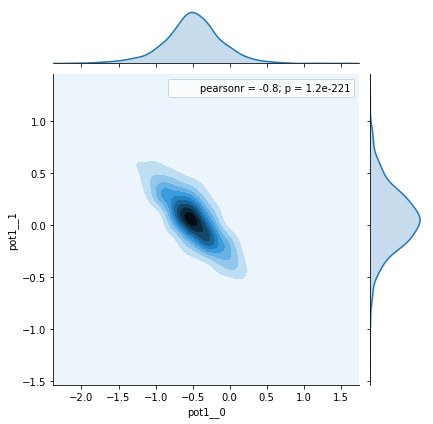

In [22]:
pm.set_tt_rng(2018)
np.random.seed(2018)
with pot1m:
    inference = pm.NFVI('planar*8', jitter=.5)
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

In [23]:
inference.fit(25000, obj_optimizer=pm.adam(learning_rate=0.01), obj_n_mc=100)

Average Loss = -1.8083: 100%|██████████████████████████████████████████████████| 25000/25000 [1:19:17<00:00,  5.25it/s]
Finished [100%]: Average Loss = -1.8086


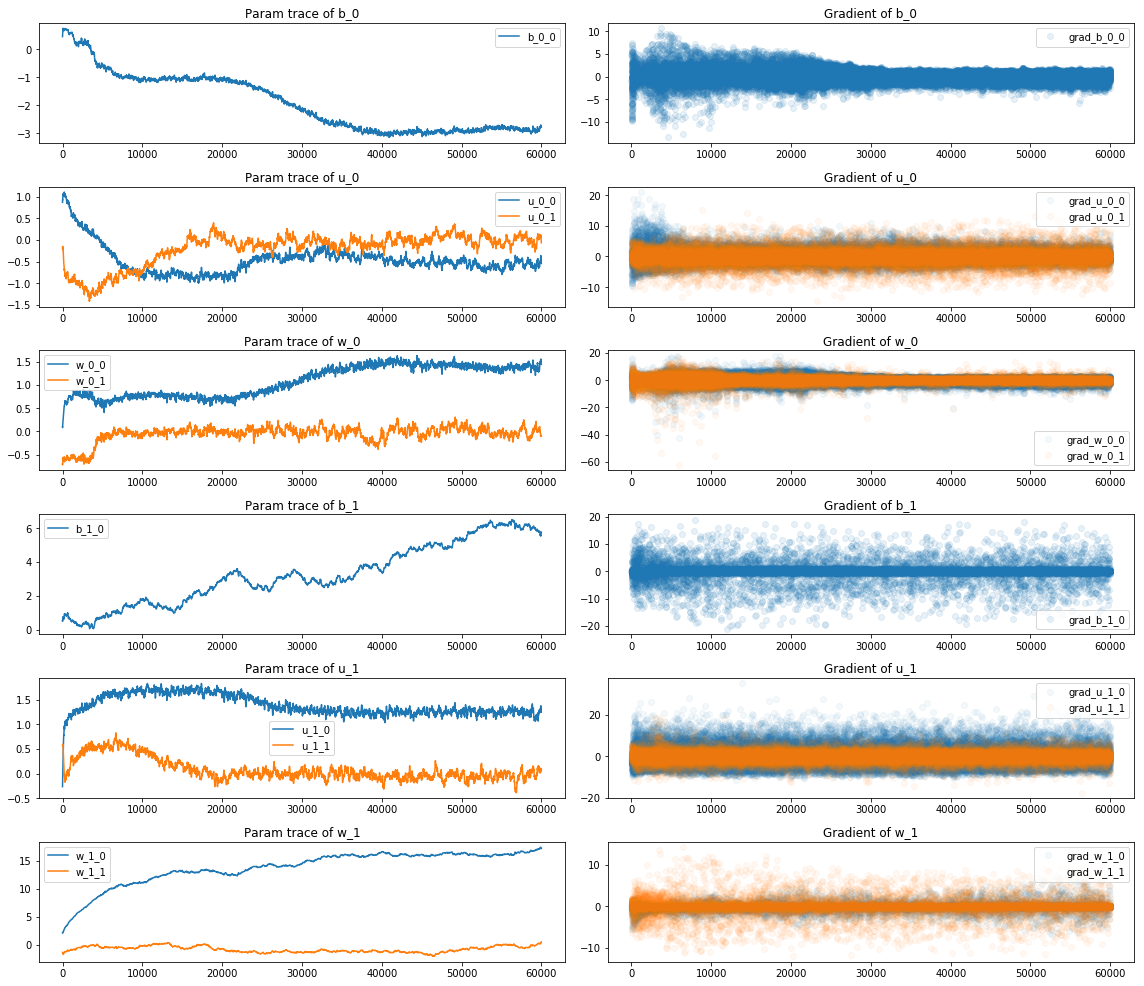

In [24]:
plot_tracker_results(tracker, "NF_flows_8_pot1.png")

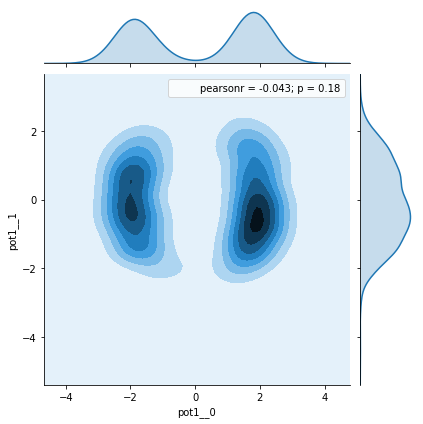

In [25]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')
plt.savefig("NF_flows_8_pot1_kde.png")

In [26]:
with pm.Model() as pot4m:
    pm.DensityDist('pot4', lambda x: -pot4(x), shape=(2,))

In [35]:
pm.set_tt_rng(2018)
np.random.seed(2018)
with pot4m:
    inference = pm.NFVI('planar*8', jitter=1)

In [36]:
inference.fit(40000, obj_optimizer=pm.adam(learning_rate=0.01), obj_n_mc=100,callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = -2.7497: 100%|██████████████████████████████████████████████████| 40000/40000 [1:56:47<00:00,  5.71it/s]
Finished [100%]: Average Loss = -2.7497


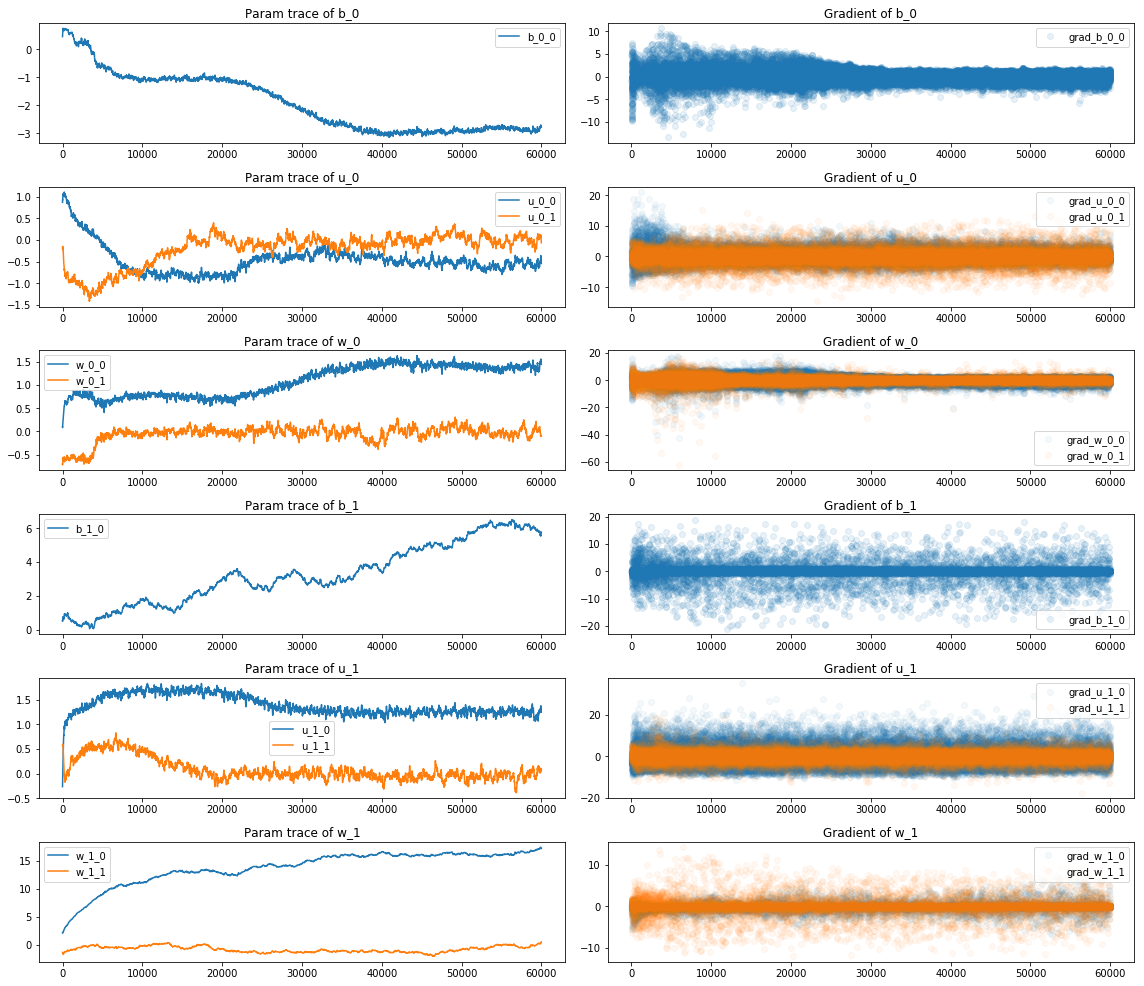

In [37]:
plot_tracker_results(tracker, "NF_flows_8_pot4_2.png")

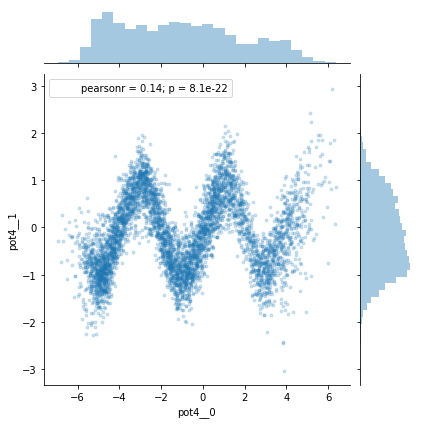

In [41]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(5000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='scatter', s=8, alpha=0.2)
plt.savefig("NF_flows_8_pot4_scat_2.png")

In [ ]:
3+4

In [ ]:
formula = 'planar*10'
with pot_m:
    inference = pm.NFVI(formula, jitter=0.1)

inference.fit(25000, obj_optimizer=pm.adam(learning_rate=.01), obj_n_mc=10)



In [ ]:
traceNF = inference.approx.sample(5000)